# Second Model (`registered` and `casual` separately)

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
#plt.style.use('dark_background')
import subprocess
%config IPCompleter.use_jedi = False

validDays = 15
minLeafSamp = 15

In [2]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [3]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [4]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [5]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [6]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [7]:
df     = pd.read_csv(path/'train.csv', low_memory=False)
dfTest = pd.read_csv(path/'test.csv', low_memory=False)

In [8]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [9]:
dfTest.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

#### Handle ordinal columns (non-numeric)

There arent any...

In [10]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

The metric that they want us to use is RMSLE (root mean square log error) to do this we can convert the dependent variable `counts`/`registered`/`casual` into `log(count)` etc. and then use RMSE as our metric which is already built in.

In [11]:
depVar   = 'count'
depVar_r = 'registered'
depVar_c = 'casual'

In [12]:
df[depVar]   = np.log(df[depVar]   + 1)
df[depVar_r] = np.log(df[depVar_r] + 1)
df[depVar_c] = np.log(df[depVar_c] + 1)

The stated loss function for this competition (root mean squared log error, RMSLE) is given as:

$$
RMSLE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(t_i+1))^2 }
$$


The above cell substitutes the targets $t_i$ for $\log(t_i + 1)$. Our models will be predicting $p_i$ from RMSE,

$$
RMSE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (p_i - t_i)^2 }
$$

So to turn the predictions back into counts we just have to exponentiate and subtract 1,

$$
\begin{align}
    \log(p_i+1) &= p_i \\
    e^{\log(p_i + 1)} &= e^{p_i} \\
    p_i &= e^{p_i} - 1
\end{align}
$$

So since our model predicts $p_i$ which is equal to $\log(p_i+1)$ we don't have to worry about the $+1$ in the prediction. Our model is predicting $\log(p_i+1)$ directly because the input target is $\log(t_i+1)$, to convert our prediciton into counts we just exponentiate and subtract 1.

For the second model we'll be predicting `registered` and `casual` separately using their own dataframes respectively. Then summing those predictions to get `count`, so we'll drop `count` for now,

In [13]:
df_r = df.drop(columns=[depVar, depVar_c])
df_c = df.drop(columns=[depVar, depVar_r])
df_r.columns, df_c.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'registered'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual'],
       dtype='object'))

### Handle dates

In [14]:
df_r   = add_datepart(df_r, 'datetime')
df_c   = add_datepart(df_c, 'datetime')
dfTest = add_datepart(dfTest, 'datetime')

In [15]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetime'

### Using TabularPandas and TabularProc

In [16]:
df_r.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'registered', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeElapsed'],
      dtype='object')

In [17]:
dfTest.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeElapsed'],
      dtype='object')

In [18]:
for col in df_r.columns:
    print(col, ':', df_r[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52  49  48  37  33  28  38  36  93  29 

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [19]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 2 days of each month in the training set, i.e. 18th--19th of each month.

In [20]:
cond = (df_r.datetimeDay>=validDays)
trainIdx = np.where(~cond)[0]
validIdx = np.where( cond)[0]

splits = (list(trainIdx), list(validIdx))

In [21]:
cont,cat = cont_cat_split(df_r, max_card=18, dep_var=depVar_r)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start'])

In [22]:
to_r = TabularPandas(df_r, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_r, 
                   splits=splits)

to_c = TabularPandas(df_c, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_c, 
                   splits=splits)


toTest = TabularPandas(dfTest, 
                       procs=procs, 
                       cat_names=cat, 
                       cont_names=cont, 
                       splits=None)

In [23]:
print('registered: ', len(to_r.train), len(to_r.valid))
print('casual:     ', len(to_c.train), len(to_c.valid))
print('test:       ', len(toTest))

registered:  8026 2860
casual:      8026 2860
test:        6493


In [24]:
to_r.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,temp,atemp,humidity,windspeed,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeElapsed,registered
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,81,0.0,52,1,1,1.293840e+09,2.639057
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,52,1,1,1.293844e+09,3.496508
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.02,13.635,80,0.0,52,1,1,1.293847e+09,3.332205
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,52,1,1,1.293851e+09,2.397895
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,9.84,14.395,75,0.0,52,1,1,1.293854e+09,0.693147


In [25]:
to_r.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,1,1,1,1,9.84,14.395,81,0.0,2.639057,1,1,52,1,6,1,1,2,1,2,1,2,1.293840e+09
1,1,1,1,1,9.02,13.635,80,0.0,3.496508,1,1,52,1,6,1,1,2,1,2,1,2,1.293844e+09
2,1,1,1,1,9.02,13.635,80,0.0,3.332205,1,1,52,1,6,1,1,2,1,2,1,2,1.293847e+09
3,1,1,1,1,9.84,14.395,75,0.0,2.397895,1,1,52,1,6,1,1,2,1,2,1,2,1.293851e+09
4,1,1,1,1,9.84,14.395,75,0.0,0.693147,1,1,52,1,6,1,1,2,1,2,1,2,1.293854e+09


In [26]:
toTest.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeElapsed
0,1,1,2,1,10.66,11.365,56,26.002701,1,1,3,20,4,20,1,1,1,1,1,1,1.295482e+09
1,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,1.295485e+09
2,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,1.295489e+09
3,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,1.295492e+09
4,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,1.295496e+09


In [27]:
save_pickle(path/'to_r.pkl',to_r)
save_pickle(path/'to_c.pkl',to_c)
save_pickle(path/'toTest.pkl', toTest)

### Creating the Decision Tree

In [28]:
#to = load_pickle(path/'to.pkl') # if i want to load it in from a previous session etc.
#toTest = load_pickle(path/'toTest.pkl')

In [29]:
xs_r,y_r = to_r.train.xs, to_r.train.y
validXs_r,validY_r = to_r.valid.xs, to_r.valid.y

xs_c,y_c = to_c.train.xs, to_c.train.y
validXs_c,validY_c = to_c.valid.xs, to_c.valid.y

testXs = toTest.xs

In [30]:
m_r = DecisionTreeRegressor(max_leaf_nodes=4)
m_c = DecisionTreeRegressor(max_leaf_nodes=4)
m_r.fit(xs_r, y_r)
m_c.fit(xs_c, y_c)

DecisionTreeRegressor(max_leaf_nodes=4)

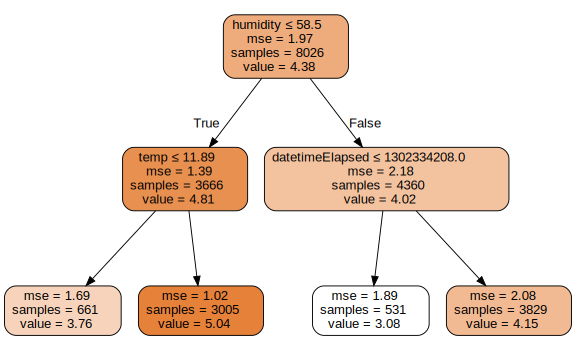

In [31]:
draw_tree(m_r, xs_r, size=8, leaves_parallel=True, precision=2)

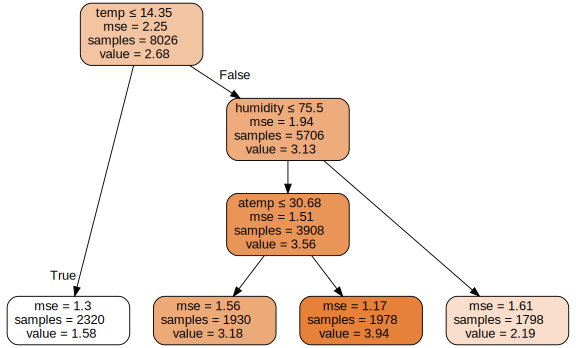

In [32]:
draw_tree(m_c, xs_c, size=8, leaves_parallel=True, precision=2)

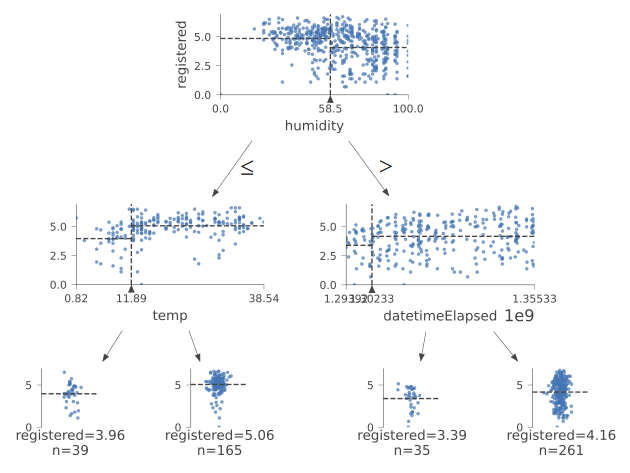

In [33]:
sampIdx = np.random.permutation(len(y_r))[:500]
dtreeviz(m_r, xs_r.iloc[sampIdx], y_r.iloc[sampIdx], xs_r.columns, depVar_r,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

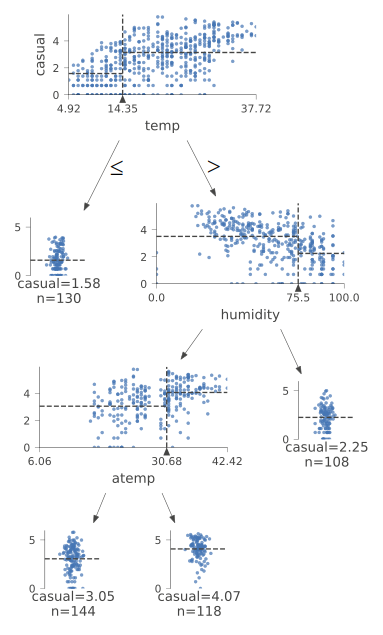

In [34]:
sampIdx = np.random.permutation(len(y_c))[:500]
dtreeviz(m_c, xs_c.iloc[sampIdx], y_c.iloc[sampIdx], xs_c.columns, depVar_c,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [35]:
m_r = DecisionTreeRegressor()
m_r.fit(xs_r, y_r)
m_c = DecisionTreeRegressor()
m_c.fit(xs_c, y_c)

DecisionTreeRegressor()

Now we'll create a function for the root mean squared error, `m_rmse`, because the competition was judged using the RMSLE (root mean squared log error) as the metric so since our counts are already the `log(counts)` using RMSE here is doing RMSLE.

In [36]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [37]:
print('registered: ', m_rmse(m_r, xs_r, y_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c))

registered:  0.0
casual:      0.0


Error is 0.0, i.e. model has perfectly fit training data because we gave it unlimited leaf nodes. Check valid to see if model is overfitting, which it obviously is,

In [38]:
print('registered: ', m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, validXs_c, validY_c))

registered:  1.621239
casual:      1.543745


So we are overfitting, because we have nearly as many leaf nodes as data points,

In [39]:
print('registered: ', m_r.get_n_leaves(), len(xs_r))
print('casual:     ', m_c.get_n_leaves(), len(xs_c))

registered:  7854 8026
casual:      7127 8026


Change stopping rule to have more data points in each leaf node,

In [40]:
m_r = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)
m_c = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)

m_r.fit(to_r.train.xs, to_r.train.y)
m_c.fit(to_c.train.xs, to_c.train.y)

print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.984954 1.327478
casual:      0.800526 1.195304


In [41]:
print('registered: ', m_r.get_n_leaves())
print('casual:     ', m_c.get_n_leaves())

registered:  408
casual:      406


### Creating a Random Forest

In [42]:
def rf(xs, y, n_estimators=200, max_samples=5_000, max_features=0.5,
       min_samples_leaf=minLeafSamp, **kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True
                                ).fit(xs, y)

In [43]:
m_r = rf(xs_r, y_r)
m_c = rf(xs_c, y_c)

In [44]:
print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  1.029241 1.189333
casual:      0.833252 1.046199


Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [45]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
print('registered: ', r_mse(preds_r.mean(0), validY_r)) # mean is the same as whole forest above
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])
print('casual:     ', r_mse(preds_c.mean(0), validY_c)) # mean is the same as whole forest above

registered:  1.189333
casual:      1.046199


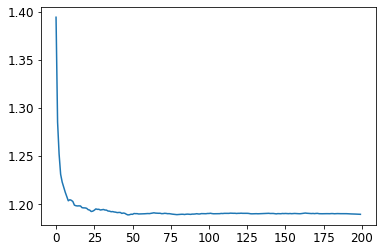

In [46]:
plt.plot([r_mse(preds_r[:i+1].mean(0), validY_r) for i in range(len(preds_r))]);

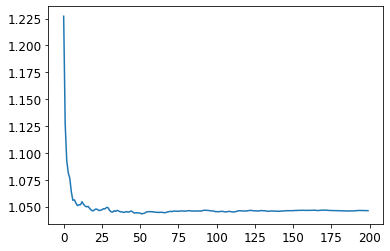

In [47]:
plt.plot([r_mse(preds_c[:i+1].mean(0), validY_c) for i in range(len(preds_c))]);

Out-of-Bag Error

In [48]:
print('train/valid registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('train/valid casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))
print('OOB         registered: ', r_mse(m_r.oob_prediction_, y_r))
print('OOB         casual:     ', r_mse(m_c.oob_prediction_, y_c))

train/valid registered:  1.029241 1.189333
train/valid casual:      0.833252 1.046199
OOB         registered:  1.107253
OOB         casual:      0.89818


OOB error being about equal to higher than validation error means that our model is generalizing slightly better to the validation set than it is to the rest of training set.

OOB error being lower than our validation error means that something else is causing that error, in addition to normal generalization error. 

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

In [49]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])

In [50]:
print('registered: ', preds_r.shape)
print('casual:     ', preds_c.shape)

registered:  (200, 2860)
casual:      (200, 2860)


In [51]:
predsSD_r = preds_r.std(0)
predsSD_c = preds_c.std(0)

In [52]:
print('registered: ', predsSD_r[:10])
print('casual:     ', predsSD_c[:10])

registered:  [0.62723517 0.64747054 0.64747054 0.6337191  0.6337191  0.62296595 0.56456701 0.57075236 0.55834401 0.5717129 ]
casual:      [0.38641819 0.37128045 0.37128045 0.36672442 0.36672442 0.36773778 0.28094107 0.35388638 0.2303797  0.3768764 ]


Some predictions are more confident than others based on whether most trees agree or not. This can be seen by varying magnitudes of standard deviation.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [53]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [54]:
fi_r = rf_feat_importance(m_r, xs_r)
fi_r[:10]

,cols,imp
15,humidity,0.272837
13,temp,0.174591
20,datetimeElapsed,0.161438
14,atemp,0.132433
19,datetimeDayofyear,0.072025
16,windspeed,0.040247
18,datetimeDay,0.030572
6,datetimeDayofweek,0.027048
17,datetimeWeek,0.026115
3,weather,0.019945


In [55]:
fi_c = rf_feat_importance(m_c, xs_c)
fi_c[:10]

,cols,imp
13,temp,0.236765
14,atemp,0.233972
15,humidity,0.230345
19,datetimeDayofyear,0.062549
2,workingday,0.047337
20,datetimeElapsed,0.046241
6,datetimeDayofweek,0.038195
17,datetimeWeek,0.031807
16,windspeed,0.018537
5,datetimeMonth,0.016253


In [56]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

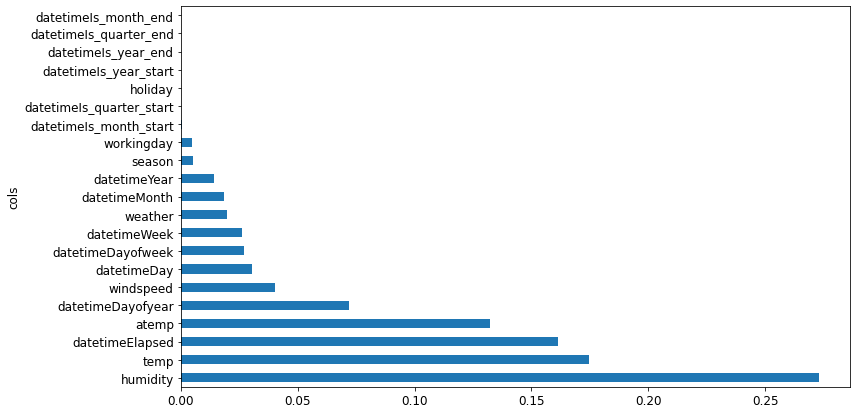

In [57]:
plot_fi(fi_r[:]);

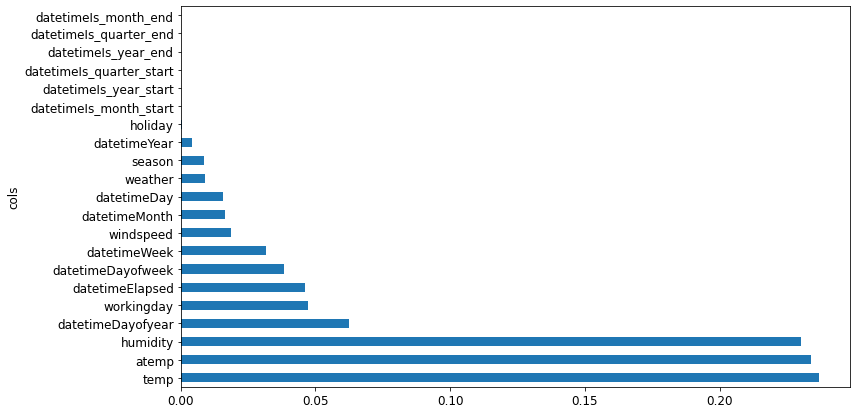

In [58]:
plot_fi(fi_c[:]);

For `registered` rentals `humidity` is the most important and `datetimeElapsed`. For `casual` rentals `temp`, `atemp`, and `humidity` are the most important. I think it's promising to see that these two types of rentals indeed have different feature importances. I think this means that separating their predictions will be beneficial.

### Remove Low-Importance Variables

In [59]:
print('registered: \n', fi_r[fi_r.imp<=0.005].cols, sep='')
print('\n')
print('casual:     \n', fi_c[fi_c.imp<=0.005].cols, sep='')

registered: 
2                   workingday
8       datetimeIs_month_start
10    datetimeIs_quarter_start
1                      holiday
12       datetimeIs_year_start
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


casual:     
4                 datetimeYear
1                      holiday
8       datetimeIs_month_start
12       datetimeIs_year_start
10    datetimeIs_quarter_start
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


The above will be dropped and the below will be kept,

In [60]:
toKeep_r = fi_r[fi_r.imp>0.005].cols
toKeep_c = fi_c[fi_c.imp>0.005].cols
print('registered: \n', toKeep_r, sep='')
print('\n')
print('casual:     \n', toKeep_c, sep='')

registered: 
15             humidity
13                 temp
20      datetimeElapsed
14                atemp
19    datetimeDayofyear
16            windspeed
18          datetimeDay
6     datetimeDayofweek
17         datetimeWeek
3               weather
5         datetimeMonth
4          datetimeYear
0                season
Name: cols, dtype: object


casual:     
13                 temp
14                atemp
15             humidity
19    datetimeDayofyear
2            workingday
20      datetimeElapsed
6     datetimeDayofweek
17         datetimeWeek
16            windspeed
5         datetimeMonth
18          datetimeDay
3               weather
0                season
Name: cols, dtype: object


I think I need to make two different test sets here because the important variables are different and I need to drop different columns for the two different predictions,

In [61]:
xsImp_r = xs_r[toKeep_r]
xsImp_c = xs_c[toKeep_c]

validXsImp_r = validXs_r[toKeep_r]
validXsImp_c = validXs_c[toKeep_c]

testXsImp_r = testXs[toKeep_r]
testXsImp_c = testXs[toKeep_c]

In [62]:
print(xsImp_r.columns == validXsImp_r.columns)
print(xsImp_r.columns == testXsImp_r.columns)

print(xsImp_c.columns == validXsImp_c.columns)
print(xsImp_c.columns == testXsImp_c.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True]


All columns for training, validation, and testing are the same for `registered` and `casual` respectively.

In [63]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

In [64]:
print('Error after importance filtering:')
print('registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

Error after importance filtering:
registered:  1.028902 1.190286
casual:      0.834465 1.045344


Our accuracy is about the same, even a bit better, and now our model is simpler to train.

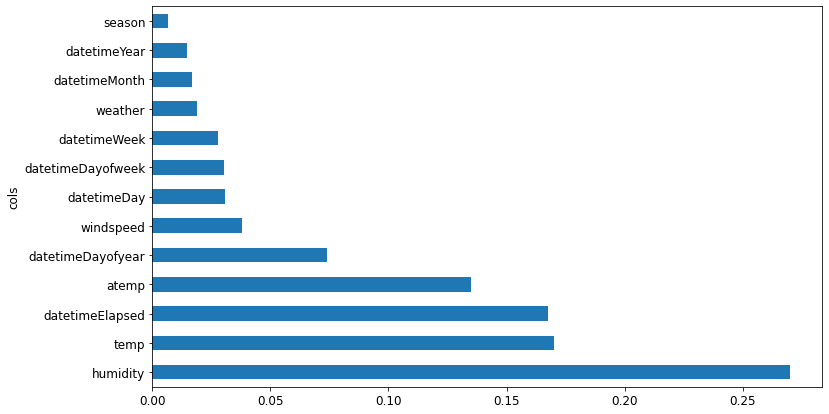

In [65]:
plot_fi(rf_feat_importance(m_r, xsImp_r));

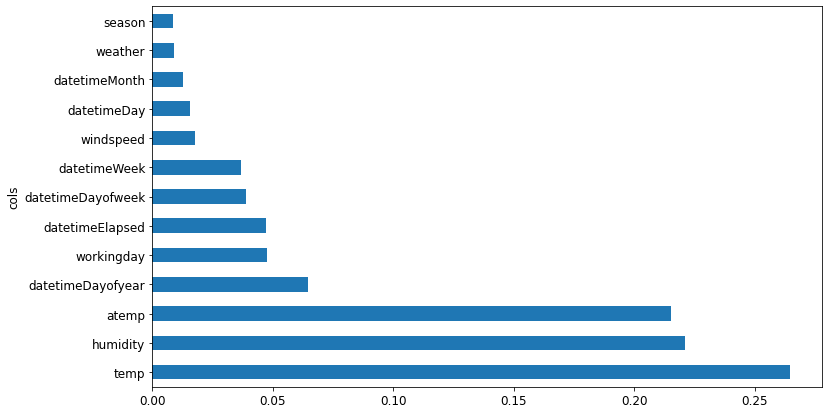

In [66]:
plot_fi(rf_feat_importance(m_c, xsImp_c));

### Remove Redundant Features

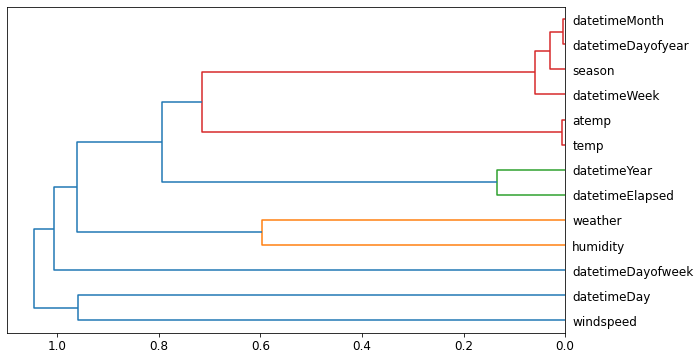

In [67]:
cluster_columns(xsImp_r)

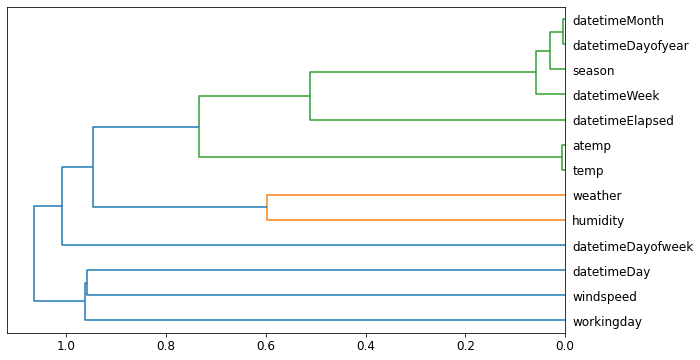

In [68]:
cluster_columns(xsImp_c)

We could try removing and `datetimeMonth / datetimeDayofyear`,

In [69]:
def get_oob(df, y):
    #m = RandomForestRegressor(n_estimators=80, min_samples_leaf=15, max_samples=None,
    #                          max_features=0.5, n_jobs=-1, oob_score=True)
    #m.fit(df, y)
    m = rf(df, y, max_samples=None)
    
    return m.oob_score_

In [70]:
print('Baseline OOB scores')
print('registered: ', get_oob(xsImp_r, y_r))
print('casual:     ', get_oob(xsImp_c, y_c))

Baseline OOB scores
registered:  0.3985804299118596
casual:      0.6567212201848316


In [71]:
print('registered:')
{c:get_oob(xsImp_r.drop(c, axis=1), y_r) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

registered:


{'temp': 0.39333666748817653,
 'atemp': 0.39810350281873375,
 'datetimeMonth': 0.3997975055382058,
 'datetimeDayofyear': 0.39900963395637457}

The OOB score for `registered` is higher after dropping `datetimeMonth` than the original OOB score above.

In [72]:
print('casual:')
{c:get_oob(xsImp_r.drop(c, axis=1), y_r) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

casual:


{'temp': 0.3917634049393004,
 'atemp': 0.3969745103491552,
 'datetimeMonth': 0.3996524988847644,
 'datetimeDayofyear': 0.39772601685322595}

The OOB score for `casual` is lower in all of the dropped variable cases than the original OOB score above.

In [73]:
print('registered: \n', xsImp_r.columns, sep='')
print('\n')
print('casual:     \n', xsImp_c.columns, sep='')

registered: 
Index(['humidity', 'temp', 'datetimeElapsed', 'atemp', 'datetimeDayofyear',
       'windspeed', 'datetimeDay', 'datetimeDayofweek', 'datetimeWeek',
       'weather', 'datetimeMonth', 'datetimeYear', 'season'],
      dtype='object')


casual:     
Index(['temp', 'atemp', 'humidity', 'datetimeDayofyear', 'workingday',
       'datetimeElapsed', 'datetimeDayofweek', 'datetimeWeek', 'windspeed',
       'datetimeMonth', 'datetimeDay', 'weather', 'season'],
      dtype='object')


In [74]:
toDrop_r = ['datetimeMonth']
toDrop_c = []
print('registered: ', get_oob(xsImp_r.drop(toDrop_r, axis=1), y_r))
print('casual:     ', get_oob(xsImp_c.drop(toDrop_c, axis=1), y_c))

registered:  0.39896252878926863
casual:      0.6573186132746744


Dropping `datetimeMonth` gives a little higher OOB score for `registered` and dropping nothing keeps `casual` the same.

In [75]:
xsFinal_r = xsImp_r.drop(toDrop_r, axis=1)
xsFinal_c = xsImp_c.drop(toDrop_c, axis=1)

validXsFinal_r = validXsImp_r.drop(toDrop_r, axis=1)
validXsFinal_c = validXsImp_c.drop(toDrop_c, axis=1)

testXsFinal_r = testXsImp_r.drop(toDrop_r, axis=1)
testXsFinal_c = testXsImp_c.drop(toDrop_c, axis=1)

xsFinal_r.columns, validXsFinal_r.columns

(Index(['humidity', 'temp', 'datetimeElapsed', 'atemp', 'datetimeDayofyear',
        'windspeed', 'datetimeDay', 'datetimeDayofweek', 'datetimeWeek',
        'weather', 'datetimeYear', 'season'],
       dtype='object'),
 Index(['humidity', 'temp', 'datetimeElapsed', 'atemp', 'datetimeDayofyear',
        'windspeed', 'datetimeDay', 'datetimeDayofweek', 'datetimeWeek',
        'weather', 'datetimeYear', 'season'],
       dtype='object'))

In [76]:
m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('registered: ', m_rmse(m_r, xsFinal_r, y_r), m_rmse(m_r, validXsFinal_r, validY_r))
print('casual:     ', m_rmse(m_c, xsFinal_c, y_c), m_rmse(m_c, validXsFinal_c, validY_c))

registered:  1.026422 1.191685
casual:      0.835311 1.045481


Valid error is a little less for `registered` than it was before redundant feature removal which makes sense because we didn't remove anything from the `casual` dataset.

### Partial Dependence

In [77]:
to_c.classes['season']

['#na#', 1, 2, 3, 4]

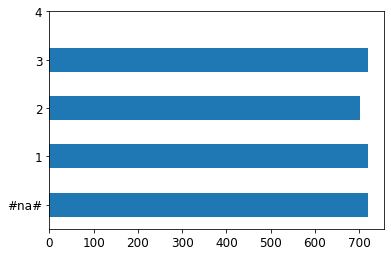

In [78]:
# all remaining variables are continuous so a bar plot doesn't really apply.
p = validXs_r['season'].value_counts(sort=False).plot.barh()
c = to_r.classes['season']
plt.yticks(ticks=range(len(c)), labels=c);

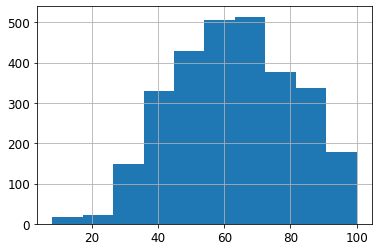

In [79]:
ax = validXsFinal_r['humidity'].hist()

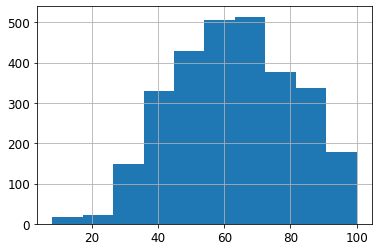

In [80]:
ax = validXsFinal_c['humidity'].hist()

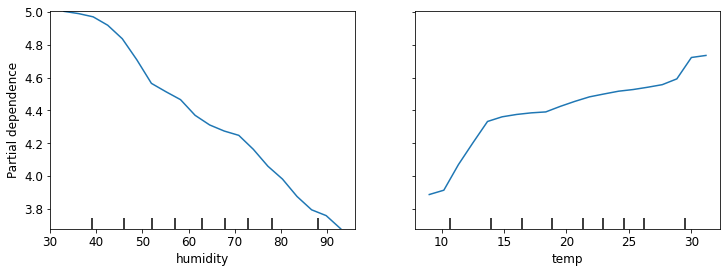

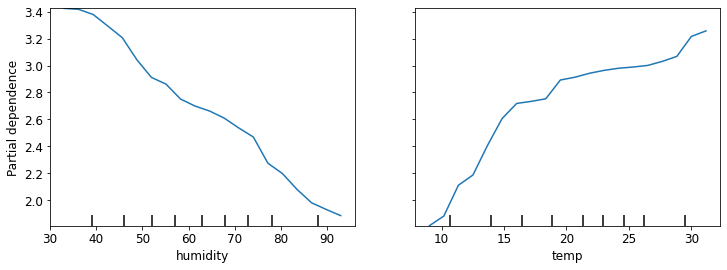

In [81]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_r, validXsFinal_r,
                        ['humidity', 'temp'],
                        grid_resolution=20, ax=ax);

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_c, validXsFinal_c,
                        ['humidity', 'temp'],
                        grid_resolution=20, ax=ax);

The ordinate (counts) is log-scale so a linear dependence is actually an exponential dependence.

### Tree Interpreter

In [82]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [83]:
row_r = validXsFinal_r.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_r, row_r.values)

In [84]:
prediction[0], bias[0], contributions[0].sum()

(array([3.3241826]), 4.383122220896364, -1.058939622414356)

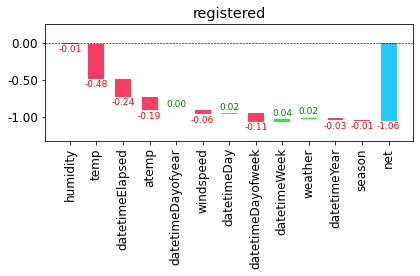

In [85]:
waterfall(validXsFinal_r.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='registered');

In [86]:
row_c = validXsFinal_c.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_c, row_c.values)

In [87]:
prediction[0], bias[0], contributions[0].sum()

(array([0.9896411]), 2.680214940338851, -1.6905738392015284)

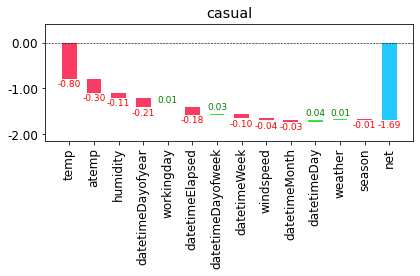

In [88]:
waterfall(validXsFinal_c.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='casual');

This information answers the question: "for predicting a particular row of data, what were the most important factors and how did they influence the prediction?"

For some of these categories the signs are flipped between `registered` and `casual`. I'm not entirely sure what that means but I'd guess that these categores have an inverse impact on count between the two types of counts which is interesting.

## Extrapolation and Neural Networks

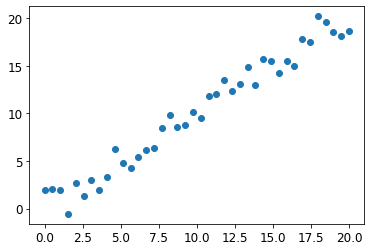

In [89]:
xLin = torch.linspace(0, 20, steps=40)
yLin = xLin + torch.randn_like(xLin)
plt.scatter(xLin, yLin);

In [90]:
xsLin = xLin[:,None]
xsLin.shape

torch.Size([40, 1])

In [91]:
mLin = RandomForestRegressor().fit(xsLin[:30], yLin[:30])

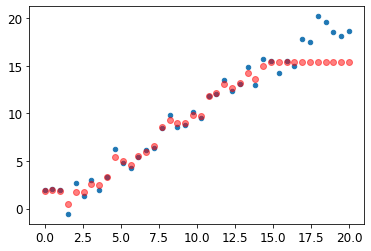

In [92]:
plt.scatter(xLin, yLin, 20)
plt.scatter(xLin, mLin.predict(xsLin), color='red', alpha=0.5);

### Finding Out-of-Domain Data

Concatenate training and validation data and label them with 0 for training and 1 for valid, then calculate importance of each column for predicting valid or not.

In [93]:
dfDom_r = pd.concat([xsFinal_r, validXsFinal_r])
isValid_r = np.array([0]*len(xsFinal_r) + [1]*len(validXsFinal_r))

dfDom_c = pd.concat([xsFinal_c, validXsFinal_c])
isValid_c = np.array([0]*len(xsFinal_c) + [1]*len(validXsFinal_c))

In [94]:
m_r = rf(dfDom_r, isValid_r)
rf_feat_importance(m_r, dfDom_r)

,cols,imp
6,datetimeDay,9.628739e-01
4,datetimeDayofyear,2.297097e-02
2,datetimeElapsed,6.727136e-03
8,datetimeWeek,4.940188e-03
1,temp,1.342784e-03
3,atemp,7.191975e-04
11,season,3.419370e-04
7,datetimeDayofweek,3.360845e-05
0,humidity,3.333613e-05
9,weather,1.533594e-05


In [95]:
m_c = rf(dfDom_c, isValid_c)
rf_feat_importance(m_c, dfDom_c)

,cols,imp
10,datetimeDay,0.956910
3,datetimeDayofyear,0.026012
5,datetimeElapsed,0.006875
7,datetimeWeek,0.006711
9,datetimeMonth,0.001909
0,temp,0.001035
1,atemp,0.000385
6,datetimeDayofweek,0.000081
8,windspeed,0.000073
2,humidity,0.000004


These are the scores of how important each column is in determining if a given row is in the validation set or the training set.

`datetimeDay` makes sense because the validation set days are at the end of the month, i.e. 16-20 based on how I set it earlier. 

`datetimeDayofyear` makes some sense for the same reason though since it ranges from 1-354 it doesn't have the same level of predictive power for valid vs. training because the numbers don't repeat as explicitly as `datetimeDay` does.

In [96]:
print('registered:')
tuple(dfDom_r.columns)

registered:


('humidity',
 'temp',
 'datetimeElapsed',
 'atemp',
 'datetimeDayofyear',
 'windspeed',
 'datetimeDay',
 'datetimeDayofweek',
 'datetimeWeek',
 'weather',
 'datetimeYear',
 'season')

In [97]:
print('casual:')
tuple(dfDom_c.columns)

casual:


('temp',
 'atemp',
 'humidity',
 'datetimeDayofyear',
 'workingday',
 'datetimeElapsed',
 'datetimeDayofweek',
 'datetimeWeek',
 'windspeed',
 'datetimeMonth',
 'datetimeDay',
 'weather',
 'season')

In [98]:
m_r = rf(xsFinal_r, y_r)
print('registered orig:', m_rmse(m_r, validXsFinal_r, validY_r))

categories = tuple(dfDom_r.columns)

for c in categories:
    m_r = rf(xsFinal_r.drop(c, axis=1), y_r)
    print(c, m_rmse(m_r, validXsFinal_r.drop(c, axis=1), validY_r))

registered orig: 1.190675
humidity 1.223682
temp 1.197889
datetimeElapsed 1.193671
atemp 1.194026
datetimeDayofyear 1.19044
windspeed 1.193171
datetimeDay 1.193944
datetimeDayofweek 1.191985
datetimeWeek 1.193649
weather 1.192528
datetimeYear 1.190743
season 1.189174


The error is lowered slightly if we remove `datetimeDayofyear`.

In [99]:
toDrop_r = ['datetimeDayofyear']

xsFinal_r = xsFinal_r.drop(columns=toDrop_r)
validXsFinal_r = validXsFinal_r.drop(columns=toDrop_r)
testXsFinal_r = testXsFinal_r.drop(columns=toDrop_r)

In [100]:
m_c = rf(xsFinal_c, y_c)
print('casual orig:', m_rmse(m_c, validXsFinal_c, validY_c))

categories = tuple(dfDom_c.columns)

for c in categories:
    m_c = rf(xsFinal_c.drop(c, axis=1), y_r)
    print(c, m_rmse(m_c, validXsFinal_c.drop(c, axis=1), validY_c))

casual orig: 1.046923
temp 2.011236
atemp 2.025506
humidity 2.078478
datetimeDayofyear 2.01747
workingday 2.020774
datetimeElapsed 2.014314
datetimeDayofweek 2.028656
datetimeWeek 2.016643
windspeed 2.022085
datetimeMonth 2.021458
datetimeDay 2.046158
weather 2.017668
season 2.033899


From the original RMSLE of 1.046923 it get's significantly worse if we drop any columns.

In [101]:
# toDrop = []

# xsFinal = xsFinal.drop(columns=toDrop)
# validXsFinal = validXsFinal.drop(columns=toDrop)
# testXsFinal = testXsFinal.drop(columns=toDrop)

# print(xsFinal.columns == validXsFinal.columns, xsFinal.columns == testXsFinal.columns)
# xsFinal.columns, validXsFinal.columns, testXsFinal.columns

Remake the model now that we've dropped columns,

In [134]:
m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 1.191521
casual final: 1.043885


Now predict the test set with only the random forest,

In [103]:
testRfY_r = m_r.predict(testXsFinal_r)
testRfY_c = m_c.predict(testXsFinal_c)

testRfY_r, testRfY_c

(array([3.73569113, 3.53564828, 3.53564828, ..., 4.07170743, 4.01697222, 3.90463966]),
 array([1.3871295 , 1.41326473, 1.41326473, ..., 1.49962244, 1.61910608, 1.41624245]))

### Using a Neural Network

In [104]:
dfNN = pd.read_csv(path/'train.csv', low_memory=False)

dfNN[depVar]   = np.log(dfNN[depVar]   + 1)
dfNN[depVar_r] = np.log(dfNN[depVar_r] + 1)
dfNN[depVar_c] = np.log(dfNN[depVar_c] + 1)

dfNN = add_datepart(dfNN, 'datetime')

In [105]:
dfNNTest = pd.read_csv(path/'test.csv', low_memory=False)
dfNNTest = add_datepart(dfNNTest, 'datetime')

In [106]:
' '.join(o for o in dfNN.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeElapsed'

We can use the work we did with the RF to trim unwanted columns for the NN. Here are the columns we kept for the RF,

In [107]:
print('registered:', xsFinal_r.columns, len(xsFinal_r.columns))
print('casual:    ', xsFinal_c.columns, len(xsFinal_c.columns))

registered: Index(['humidity', 'temp', 'datetimeElapsed', 'atemp', 'windspeed',
       'datetimeDay', 'datetimeDayofweek', 'datetimeWeek', 'weather',
       'datetimeYear', 'season'],
      dtype='object') 11
casual:     Index(['temp', 'atemp', 'humidity', 'datetimeDayofyear', 'workingday',
       'datetimeElapsed', 'datetimeDayofweek', 'datetimeWeek', 'windspeed',
       'datetimeMonth', 'datetimeDay', 'weather', 'season'],
      dtype='object') 13


In [108]:
dfNNFinal_r = dfNN[list(xsFinal_r.columns) + [depVar_r]]
dfNNFinal_r

,humidity,temp,datetimeElapsed,atemp,windspeed,datetimeDay,datetimeDayofweek,datetimeWeek,weather,datetimeYear,season,registered
0,81,9.84,1.293840e+09,14.395,0.0000,1,5,52,1,2011,1,2.639057
1,80,9.02,1.293844e+09,13.635,0.0000,1,5,52,1,2011,1,3.496508
2,80,9.02,1.293847e+09,13.635,0.0000,1,5,52,1,2011,1,3.332205
3,75,9.84,1.293851e+09,14.395,0.0000,1,5,52,1,2011,1,2.397895
4,75,9.84,1.293854e+09,14.395,0.0000,1,5,52,1,2011,1,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,50,15.58,1.355944e+09,19.695,26.0027,19,2,51,1,2012,4,5.799093
10882,57,14.76,1.355947e+09,17.425,15.0013,19,2,51,1,2012,4,5.446737
10883,61,13.94,1.355951e+09,15.910,15.0013,19,2,51,1,2012,4,5.105945
10884,61,13.94,1.355954e+09,17.425,6.0032,19,2,51,1,2012,4,4.770685


In [109]:
dfNNFinal_c = dfNN[list(xsFinal_c.columns) + [depVar_c]]
dfNNFinal_c

,temp,atemp,humidity,datetimeDayofyear,workingday,datetimeElapsed,datetimeDayofweek,datetimeWeek,windspeed,datetimeMonth,datetimeDay,weather,season,casual
0,9.84,14.395,81,1,0,1.293840e+09,5,52,0.0000,1,1,1,1,1.386294
1,9.02,13.635,80,1,0,1.293844e+09,5,52,0.0000,1,1,1,1,2.197225
2,9.02,13.635,80,1,0,1.293847e+09,5,52,0.0000,1,1,1,1,1.791759
3,9.84,14.395,75,1,0,1.293851e+09,5,52,0.0000,1,1,1,1,1.386294
4,9.84,14.395,75,1,0,1.293854e+09,5,52,0.0000,1,1,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,354,1,1.355944e+09,2,51,26.0027,12,19,1,4,2.079442
10882,14.76,17.425,57,354,1,1.355947e+09,2,51,15.0013,12,19,1,4,2.397895
10883,13.94,15.910,61,354,1,1.355951e+09,2,51,15.0013,12,19,1,4,1.609438
10884,13.94,17.425,61,354,1,1.355954e+09,2,51,6.0032,12,19,1,4,2.564949


In [110]:
dfNNFinalTest_r = dfNNTest[list(xsFinal_r.columns)]
dfNNFinalTest_r

,humidity,temp,datetimeElapsed,atemp,windspeed,datetimeDay,datetimeDayofweek,datetimeWeek,weather,datetimeYear,season
0,56,10.66,1.295482e+09,11.365,26.0027,20,3,3,1,2011,1
1,56,10.66,1.295485e+09,13.635,0.0000,20,3,3,1,2011,1
2,56,10.66,1.295489e+09,13.635,0.0000,20,3,3,1,2011,1
3,56,10.66,1.295492e+09,12.880,11.0014,20,3,3,1,2011,1
4,56,10.66,1.295496e+09,12.880,11.0014,20,3,3,1,2011,1
...,...,...,...,...,...,...,...,...,...,...,...
6488,60,10.66,1.356980e+09,12.880,11.0014,31,0,1,2,2012,1
6489,60,10.66,1.356984e+09,12.880,11.0014,31,0,1,2,2012,1
6490,60,10.66,1.356988e+09,12.880,11.0014,31,0,1,1,2012,1
6491,56,10.66,1.356991e+09,13.635,8.9981,31,0,1,1,2012,1


In [111]:
dfNNFinalTest_c = dfNNTest[list(xsFinal_c.columns)]
dfNNFinalTest_c

,temp,atemp,humidity,datetimeDayofyear,workingday,datetimeElapsed,datetimeDayofweek,datetimeWeek,windspeed,datetimeMonth,datetimeDay,weather,season
0,10.66,11.365,56,20,1,1.295482e+09,3,3,26.0027,1,20,1,1
1,10.66,13.635,56,20,1,1.295485e+09,3,3,0.0000,1,20,1,1
2,10.66,13.635,56,20,1,1.295489e+09,3,3,0.0000,1,20,1,1
3,10.66,12.880,56,20,1,1.295492e+09,3,3,11.0014,1,20,1,1
4,10.66,12.880,56,20,1,1.295496e+09,3,3,11.0014,1,20,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,10.66,12.880,60,366,1,1.356980e+09,0,1,11.0014,12,31,2,1
6489,10.66,12.880,60,366,1,1.356984e+09,0,1,11.0014,12,31,2,1
6490,10.66,12.880,60,366,1,1.356988e+09,0,1,11.0014,12,31,1,1
6491,10.66,13.635,56,366,1,1.356991e+09,0,1,8.9981,12,31,1,1


##### `registered`

In [112]:
contNN_r,catNN_r = cont_cat_split(dfNNFinal_r, max_card=18, dep_var=depVar_r)

In [113]:
dfNNFinal_r[catNN_r].nunique()

datetimeDayofweek    7
weather              4
datetimeYear         2
season               4
dtype: int64

In [114]:
dfNNFinal_r[contNN_r].nunique()

humidity              89
temp                  49
datetimeElapsed    10886
atemp                 60
windspeed             28
datetimeDay           19
datetimeWeek          46
dtype: int64

It seems to me that some of these variables although somewhat lower in cardinality are continuous in nature.

Specifically, `datetimeDayofyear` and `datetimeWeek` are categorical in nature, I think.

In [115]:
for i in ['datetimeDay', 'datetimeWeek']:
    contNN_r.remove(i)
    catNN_r.append(i)
    
print('catNN:', catNN_r)
print('contNN:', contNN_r)

catNN: ['datetimeDayofweek', 'weather', 'datetimeYear', 'season', 'datetimeDay', 'datetimeWeek']
contNN: ['humidity', 'temp', 'datetimeElapsed', 'atemp', 'windspeed']


##### `casual`

In [116]:
contNN_c,catNN_c = cont_cat_split(dfNNFinal_c, max_card=18, dep_var=depVar_c)

In [117]:
dfNNFinal_c[catNN_c].nunique()

workingday            2
datetimeDayofweek     7
datetimeMonth        12
weather               4
season                4
dtype: int64

In [118]:
dfNNFinal_c[contNN_c].nunique()

temp                    49
atemp                   60
humidity                89
datetimeDayofyear      238
datetimeElapsed      10886
datetimeWeek            46
windspeed               28
datetimeDay             19
dtype: int64

In [119]:
for i in ['datetimeDay', 'datetimeWeek']:
    contNN_c.remove(i)
    catNN_c.append(i)
    
print('catNN:', catNN_c)
print('contNN:', contNN_c)

catNN: ['workingday', 'datetimeDayofweek', 'datetimeMonth', 'weather', 'season', 'datetimeDay', 'datetimeWeek']
contNN: ['temp', 'atemp', 'humidity', 'datetimeDayofyear', 'datetimeElapsed', 'windspeed']


Testing dataframes don't need to be checked because we altered the lists of columns themselves.

Create `TabularPandas` object in the same was as before but with `Normalize` since we're using it for an NN.

In [120]:
procsNN = [Categorify, FillMissing, Normalize]
toNN_r = TabularPandas(dfNNFinal_r,
                       procs=procs,
                       cat_names=catNN_r,
                       cont_names=contNN_r,
                       y_names=depVar_r,
                       splits=splits)

toNN_c = TabularPandas(dfNNFinal_c,
                       procs=procs,
                       cat_names=catNN_c,
                       cont_names=contNN_c,
                       y_names=depVar_c,
                       splits=splits)

toNNtest_r = TabularPandas(dfNNFinalTest_r,
                           procs=procs,
                           cat_names=catNN_r,
                           cont_names=contNN_r,
                           splits=None)

toNNtest_c = TabularPandas(dfNNFinalTest_c,
                           procs=procs,
                           cat_names=catNN_c,
                           cont_names=contNN_c,
                           splits=None)

Tabular models don't generally need much GPU ram so we can have bigger batch sizes,

In [121]:
dls_r = toNN_r.dataloaders(1024)
dls_c = toNN_c.dataloaders(1024)

dlsTest_r = toNNtest_r.dataloaders(1024)
dlsTest_c = toNNtest_c.dataloaders(1024)

In [122]:
y_r = toNN_r.train.y
print('registered:', y_r.min(), y_r.max())
y_c = toNN_c.train.y
print('casual:', y_c.min(), y_c.max())

registered: 0.0 6.787845
casual: 0.0 5.894403


In [123]:
#F.mse_loss??

In [124]:
learn_r = tabular_learner(dls_r, layers=[200,100], n_out=1,
                        y_range=(0,7), loss_func=F.mse_loss)
learn_c = tabular_learner(dls_c, layers=[200,100], n_out=1,
                        y_range=(0,6), loss_func=F.mse_loss)

registered:
lrMin/10: 0.012022644281387329 lrSteep: 0.0014454397605732083


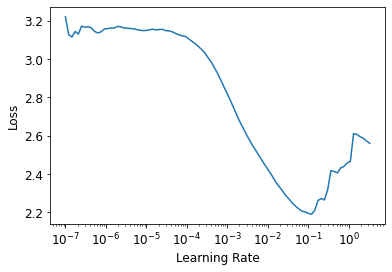

In [125]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.010000000149011612 lrSteep: 0.0010000000474974513


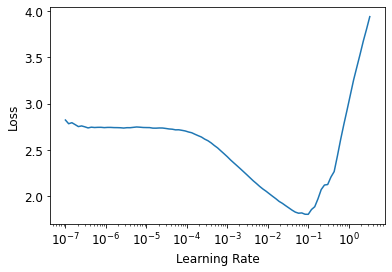

In [126]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

In [127]:
learn_r.fit_one_cycle(10, lr_max=lrMin_r)

epoch,train_loss,valid_loss,time
0,2.255724,5.669189,00:00
1,1.866266,2.584107,00:00
2,1.683810,2.113735,00:00
3,1.573520,1.753490,00:00
4,1.483942,1.634504,00:00
5,1.413979,1.584809,00:00
6,1.353597,1.566483,00:00
7,1.302002,1.506849,00:00
8,1.255440,1.502153,00:00
9,1.217371,1.516250,00:00


In [128]:
learn_c.fit_one_cycle(10, lr_max=lrMin_c)

epoch,train_loss,valid_loss,time
0,1.985762,2.050894,00:00
1,1.514649,1.425929,00:00
2,1.302752,1.455078,00:00
3,1.157479,1.339280,00:00
4,1.056633,1.540850,00:00
5,0.984595,1.517079,00:00
6,0.923095,1.373093,00:00
7,0.873775,1.307753,00:00
8,0.831632,1.230390,00:00
9,0.797847,1.199301,00:00


In [133]:
preds_r,targs_r = learn_r.get_preds()
print('registered:', r_mse(preds_r, targs_r))
preds_c,targs_c = learn_c.get_preds()
print('casual:    ', r_mse(preds_c, targs_c))

registered: 1.231361


casual:     1.095126


## Ensembling

In [130]:
rfPreds_r = m_r.predict(validXsFinal_r)
rfPreds_c = m_c.predict(validXsFinal_c)

ensPreds_r = (to_np(preds_r.squeeze()) + rfPreds_r) /2
ensPreds_c = (to_np(preds_c.squeeze()) + rfPreds_c) /2

In [135]:
print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 1.191521
casual final: 1.043885


In [132]:
print('registered:', r_mse(ensPreds_r, validY_r))
print('casaul:    ', r_mse(ensPreds_c, validY_c))

registered: 1.188371
casaul:     1.039246


This is slightly better than the RF method result. We could try Boosting or using Embeddings.

Now need to convert the predictions to an array of `counts`. Do this by exponentiating and then subtracting 1 and then summing the resulting values.